In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import zipfile
import glob
import os
import torch as th
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras_preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.applications.resnet import preprocess_input

In [2]:
%pwd

'd:\\mjourFinalPorject\\research'

In [3]:
os.chdir("D://mjourFinalPorject//artifacts//data_ingestion//dcdata")

In [4]:
%pwd

'D:\\mjourFinalPorject\\artifacts\\data_ingestion\\dcdata'

In [5]:
#instantiate the constants
batch_size = 16
img_size = 224
epochs = 50

In [6]:
print(len(os.listdir('D://mjourFinalPorject//artifacts//data_ingestion//dcdata//train')), "training data")
print(len(os.listdir('D://mjourFinalPorject//artifacts//data_ingestion//dcdata//test')), "test data")
os.listdir("D:/mjourFinalPorject/artifacts/data_ingestion/dcdata")


4800 training data
2400 test data


['test', 'train']

<a id='sec1.2'></a>
## [1.2 Data Formatting](#sec1.2)

In our data formatting, we will generate the respective labels for **dogs (1)** and **cats (0)** for our training data. File path will also be collected as a column for our dataframe so that it can be used to load and train our images

In [7]:
def gen_label(directory):
    label = []
    for file in os.listdir(directory):
        if (file.split('.')[0] == 'dog'):
            label.append(str(1))
        elif (file.split('.')[0] == 'cat'):
            label.append(str(0))
    return label
    #print(len(label),"files in", directory)
    
def get_path(directory):
    path = []
    for files in os.listdir(directory):
        path.append(files)
    return path

train_y = gen_label('train')
train_x = get_path('train')
test_x = get_path('test')

       filename category
0     cat.0.jpg        0
1     cat.1.jpg        0
2    cat.10.jpg        0
3   cat.100.jpg        0
4  cat.1000.jpg        0


Text(0.5, 1.0, 'Data Distribution')

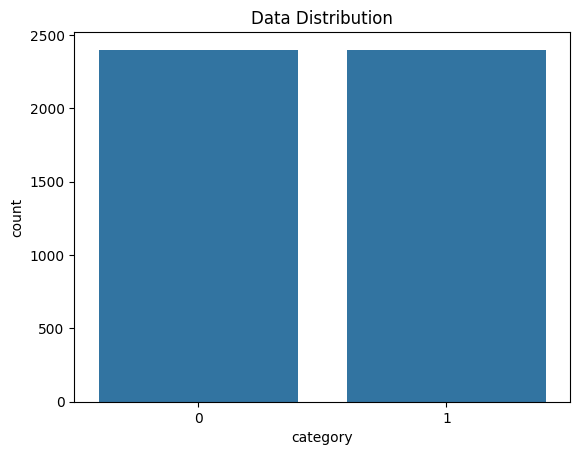

In [8]:
df = pd.DataFrame({'filename': train_x,
                  'category': train_y})
print(df.head())

sns.countplot(x='category',data=df).set_title("Data Distribution")

### Lets visualise one of the training image

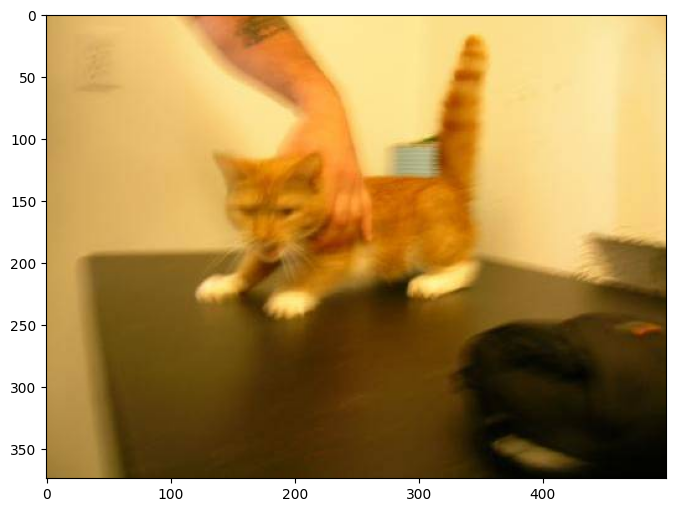

In [9]:
# Change working directory
os.chdir('train')

img = load_img(df['filename'].iloc[0]) 
  
# Displaying the image 
plt.figure(figsize=(8,8))
plt.imshow(img)

<a id="sec1.3"></a>
## [1.3 Generating mini batches for training](#sec1.3)

Before we move on from here, i would like discuss the following terms that you might have often come across; **Batch Gradient Descent**, **Stochastic Gradient Descent**, **Mini-Batch Gradient Descent**.  

In machine learning terms, the word **gradient descent** refers to a specific optimization algorithm whose purpose it to minimise the loss function of any machine learning algorithm. Gradient Descent does so by calculating the gradient of the weights parameters with respect to the loss function, and using it to find a global minimum of the loss function.

**Batch Gradient Descent** uses the entire training data to make one gradient computation; which results in slow convergence since the gradient descent only makes a single step with every epoch.  
**Stochastic Gradient Descent** makes a gradient calculation with a single training sample, which will result in loss of speedup from the vectorization.  
**Mini-Batch Gradient Descent** uses a mini-batches of training example for each gradient calculation; which makes convergence faster, and at the same time, utilise the speed up from vectorization.

We will first split our training data into training and validation set


In [10]:
train_df, valid_df = train_test_split(df, test_size=0.25)
print(train_df.shape)
print(valid_df.shape)

(3600, 2)
(1200, 2)


Keras library provides module for generating mini batches of augmented data that we can directly feed into our CNN model, which provides convenience as we just have to feed in the dataframe with relevant file path and labels. Not only that, the dataset generated can be wrapped with transformation for data augmentation so that our mini-batches will consist of data with transformation, adding more data to prevent model overfitting.  
*ImageDataGenerator* is a class that provides a variety of ways we can futher augment our data, find more [here](https://keras.io/preprocessing/image/). Data augmentation is only added to our training data.  
*flow_from_dataframe()* method will accept dataframe with filenames as x_column and labels as y_column to generate mini-batches

In [11]:
def generate_train_batch(model):
    
    if model == 'resnet':      #use of resnet requires its specific preprocessing_function for better accuracy for augmentation
        print('resnet data')
        train_datagen = ImageDataGenerator(
                    rotation_range=10,
                    zoom_range=0.1,
                    horizontal_flip=True,
                    fill_mode='nearest',
                    width_shift_range=0.1,
                    height_shift_range=0.1,
                    preprocessing_function = preprocess_input)

    else:
        train_datagen = ImageDataGenerator(    #standard augmentation
                    rotation_range=10,
                    rescale=1./255,
                    zoom_range=0.1,
                    horizontal_flip=True,
                    fill_mode='nearest',
                    width_shift_range=0.1,
                    height_shift_range=0.1)

    if model == 'vgg':   #VGG16 will only generate mini-batches of x_features; y_col=None as feature extractor
        print('vgg data')
        train_gen = train_datagen.flow_from_dataframe(
            train_df[['filename']],
            x_col='filename',
            y_col=None,
            target_size=(img_size, img_size),
            batch_size = batch_size,
            class_mode=None,
            shuffle=False)
        
    else:
        train_gen = train_datagen.flow_from_dataframe(
                    train_df,
                    x_col='filename',
                    y_col='category',
                    target_size=(img_size, img_size),
                    batch_size = batch_size,
                    class_mode='binary')

    return train_gen


def generate_valid_batch(model):
    if model == 'resnet':
        print('resnet validation set')
        valid_datagen = ImageDataGenerator(preprocessing_function = preprocess_input)
    else:
        valid_datagen = ImageDataGenerator(rescale=1./255)
        
    valid_gen = valid_datagen.flow_from_dataframe(
            valid_df,
            x_col='filename',
            y_col='category',
            target_size=(img_size, img_size),
            batch_size = batch_size,
            class_mode='binary')
    
    return valid_gen

train_gen = generate_train_batch('others')
valid_gen = generate_valid_batch('others')

Found 3600 validated image filenames belonging to 2 classes.
Found 1200 validated image filenames belonging to 2 classes.


#### Data Augmentation
We can visualize the effect of a random image after data augmentation

Found 1 validated image filenames belonging to 1 classes.


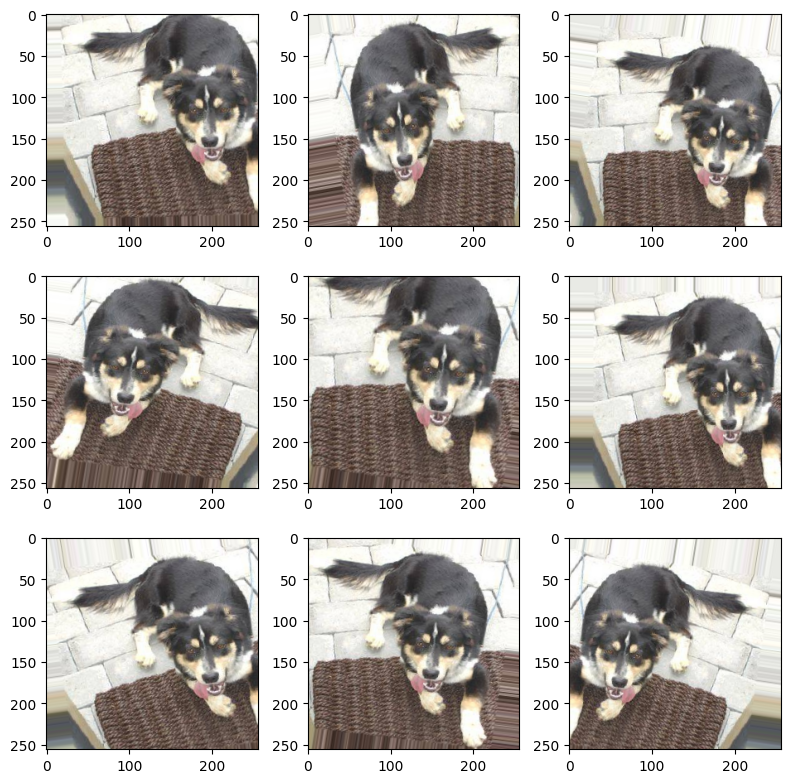

In [12]:
visual_datagen = ImageDataGenerator(    #standard augmentation
                    rotation_range=10,
                    rescale=1./255,
                    zoom_range=0.1,
                    horizontal_flip=True,
                    fill_mode='nearest',
                    width_shift_range=0.1,
                    height_shift_range=0.1)

visualise_df = train_df.sample(n=1).reset_index(drop=True)
visualisation_generator = visual_datagen.flow_from_dataframe(
    visualise_df,  
    x_col='filename',
    y_col='category'
)
plt.figure(figsize=(8, 8))
for i in range(0, 9):
    plt.subplot(3, 3, i+1)
    for X_batch, Y_batch in visualisation_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

<a id="sec2"></a>
# [2. CNN Architecture](#sec2)

Convolutional Neural Network (CNN) has been the to-go neural network architecture when dealing with images. From Yann LeCunn's LeNet in 1990s predicting digits on the popular MNIST data, to Alexnet impressive performance on ImageNet, the area of CNN has evolved tremendously.  
A simple architecture of CNN is shown below:   

![cnn](https://www.researchgate.net/profile/Keiron_Oshea/publication/285164623/figure/fig4/AS:667895516377100@1536250108959/An-simple-CNN-architecture-comprised-of-just-five-layers.png)  
  
**Convolution Layer** uses filters to extract meaningful edges, features in an image, through a combination of linear and non-linear process. Linear operation invloves the correlation between filters and image pixels.Non-linear operations includes ReLU, Tanh.  
![convolution](https://developers.google.com/machine-learning/practica/image-classification/images/convolution_overview.gif)  


**Pooling Layer** aims at reducing the spatial size of the feature map in order to reduce the number of parameters and computation complexity. Some commonly used pooling methods include average pooling, max pooling.  
![pooling](https://developers.google.com/machine-learning/practica/image-classification/images/maxpool_animation.gif)

Images are retreived from [google](https://developers.google.com/machine-learning/practica/image-classification/convolutional-neural-networks)

<a id="sec2.1"></a>
## [2.1 CNN from scratch](#sec2.1)

In this section, we will try to implement a CNN architecture from scratch, using the Keras library. We will be using just 5 epochs for all our training

In [13]:
from keras.applications import VGG16, resnet
from keras.layers import *
from keras.models import Model,Sequential
from keras import optimizers
from keras import regularizers

In [14]:
from keras import backend as K
K.clear_session()

For our simple CNN, we will use 3 convolutional layers with all having the same filter size of (3x3). Each convolutional layers will be followed by a Max pooling layer that will reduce the dimensions of the convolutional features maps. The output of the final convolutional layer will be passed into a Fully connected layer with 500 neurons, and connecting to the last layer, which acts as sigmoid activation to predict 1/0.

In [15]:
modelcnn=Sequential()
modelcnn.add(Conv2D(16, (3,3), activation="relu", input_shape=(img_size, img_size, 3)))
modelcnn.add(Conv2D(16, (3,3), activation="relu",))
modelcnn.add(MaxPooling2D((3,3)))

modelcnn.add(Conv2D(32, (3,3), activation="relu"))
modelcnn.add(Conv2D(32, (3,3), activation="relu"))
modelcnn.add(MaxPooling2D(2,2))

modelcnn.add(Conv2D(64, (3,3), activation="relu"))
modelcnn.add(Conv2D(64, (3,3), activation="relu"))
modelcnn.add(MaxPooling2D(2,2))
modelcnn.add(Dropout(0.3))

modelcnn.add(Conv2D(32, (3,3), activation="relu"))
modelcnn.add(MaxPooling2D((2,2)))

modelcnn.add(Flatten())
modelcnn.add(Dense(512, activation="relu"))
modelcnn.add(Dropout(0.5))
modelcnn.add(Dense(1, activation="sigmoid"))

modelcnn.compile(loss="binary_crossentropy", 
         optimizer=optimizers.RMSprop(lr=1e-4),
         metrics=["accuracy"])

d:\mjourfinalporject\mf\lib\site-packages\keras\optimizers\optimizer_v2\rmsprop.py:140: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [16]:
modelcnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 16)      448       
                                                                 
 conv2d_1 (Conv2D)           (None, 220, 220, 16)      2320      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 73, 73, 16)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 71, 71, 32)        4640      
                                                                 
 conv2d_3 (Conv2D)           (None, 69, 69, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 34, 34, 32)       0         
 2D)                                                    

Lets fit our model with the training data and evaluate its performance


In [17]:
history = modelcnn.fit_generator(train_gen,
                    epochs=epochs,
                    validation_data=valid_gen)

C:\Users\dongr\AppData\Local\Temp\ipykernel_14448\3236308057.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = modelcnn.fit_generator(train_gen,


Epoch 1/50
225/225 [==============================] - 48s 171ms/step - loss: 0.6925 - accuracy: 0.5086 - val_loss: 0.6905 - val_accuracy: 0.4833
Epoch 2/50
225/225 [==============================] - 41s 181ms/step - loss: 0.6833 - accuracy: 0.5614 - val_loss: 0.6924 - val_accuracy: 0.4983
Epoch 3/50
225/225 [==============================] - 37s 165ms/step - loss: 0.6645 - accuracy: 0.6072 - val_loss: 0.6630 - val_accuracy: 0.6192
Epoch 4/50
225/225 [==============================] - 34s 153ms/step - loss: 0.6515 - accuracy: 0.6231 - val_loss: 0.6665 - val_accuracy: 0.5775
Epoch 5/50
225/225 [==============================] - 31s 138ms/step - loss: 0.6316 - accuracy: 0.6500 - val_loss: 0.5808 - val_accuracy: 0.7108
Epoch 6/50
225/225 [==============================] - 32s 141ms/step - loss: 0.6151 - accuracy: 0.6644 - val_loss: 0.5662 - val_accuracy: 0.7200
Epoch 7/50
225/225 [==============================] - 34s 149ms/step - loss: 0.5983 - accuracy: 0.6747 - val_loss: 0.5578 - val_ac

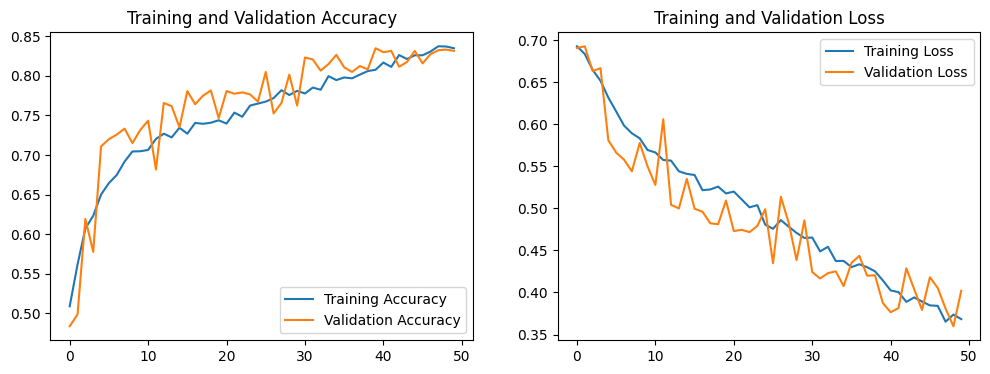

In [18]:
import matplotlib.pyplot as plt

# Retrieve history data
history_dict = history.history

# Extract values for plotting
train_acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
train_loss = history_dict['loss']
val_loss = history_dict['val_loss']

# Number of epochs
epochs_range = range(len(train_acc))

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()


In [20]:
from tensorflow.keras.models import load_model
# Load the model from the HDF5 file
modelcnn.save('modelcnn.h5')  # HDF5 format
loaded_model = load_model('modelcnn.h5')  # HDF5 format
loss, accuracy = loaded_model.evaluate(valid_gen)
print(f"Loaded model accuracy: {accuracy}")


75/75 [==============================] - 3s 37ms/step - loss: 0.4020 - accuracy: 0.8317
Loaded model accuracy: 0.8316666483879089


In [21]:
hist_df = pd.DataFrame(history.history)
print(hist_df)

        loss  accuracy  val_loss  val_accuracy
0   0.692522  0.508611  0.690540      0.483333
1   0.683312  0.561389  0.692442      0.498333
2   0.664476  0.607222  0.663033      0.619167
3   0.651537  0.623056  0.666507      0.577500
4   0.631565  0.650000  0.580834      0.710833
5   0.615082  0.664444  0.566206      0.720000
6   0.598323  0.674722  0.557791      0.725833
7   0.589136  0.691667  0.543966      0.733333
8   0.583196  0.704444  0.577617      0.715000
9   0.569273  0.704722  0.549860      0.731667
10  0.566364  0.706389  0.527747      0.743333
11  0.557402  0.720278  0.605816      0.681667
12  0.556648  0.726944  0.504152      0.765833
13  0.543923  0.722222  0.499805      0.761667
14  0.540926  0.734444  0.535084      0.735000
15  0.539533  0.726944  0.499480      0.780833
16  0.521542  0.740556  0.496027      0.764167
17  0.522384  0.739444  0.482192      0.775000
18  0.525796  0.740833  0.481044      0.781667
19  0.517660  0.743889  0.509262      0.746667
20  0.519876 

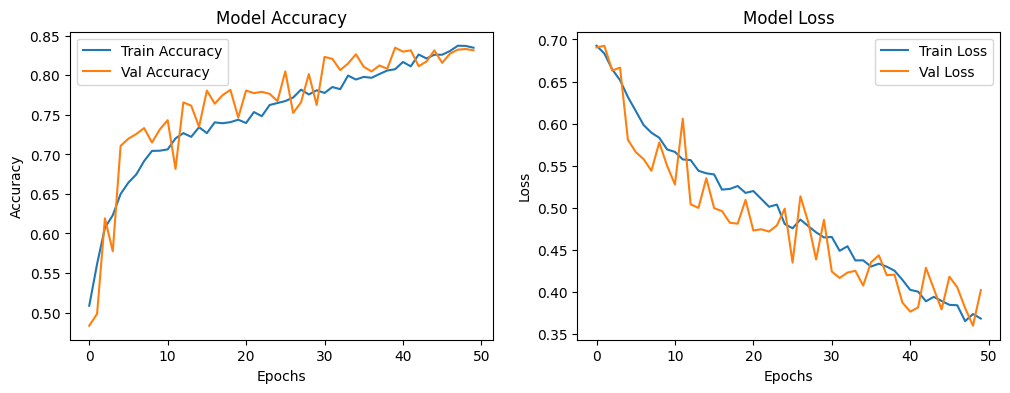

In [22]:
# Plotting the training history
plt.figure(figsize=(12, 4))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [23]:
loss, accuracy = modelcnn.evaluate_generator(valid_gen, valid_gen.samples//batch_size, workers=12)
print("Validation: accuracy = %f  ;  loss = %f " % (accuracy, loss))

C:\Users\dongr\AppData\Local\Temp\ipykernel_14448\1399065358.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  loss, accuracy = modelcnn.evaluate_generator(valid_gen, valid_gen.samples//batch_size, workers=12)


Validation: accuracy = 0.831667  ;  loss = 0.402008 


<a id="sec2.2"></a>
## [2.2 Transfer Learning](#sec2.2)

In the following sections, we will be focusing on **Pre-trained** models. Pre-trained models are architectures are were previously trained using large datasets to solve similar problems that we are trying to solve; which is image classification.  
One benefits of using pre-trained model is that because these models has been trained on huge datasets, they are used to learning very good discriminative features, enabling us to use it for transfer learning.  
**Transfer learning** is process of reusing a pretained model trained for a task and use it for another task. Two approaches for transfer learning are:
1. Feature Extraction
2. Fine Tuning

<a id="sec2.2.1"></a>
### [2.2.1 Feature Extraction](#sec2.2.1)

One of the approach for transfer learning is **feature extraction**, where we leverage on the pretrained models to predict a set of output features, and feeding these output features into a separate classifier algorithm to generate prediction. In this case, we will be using [VGG16](https://arxiv.org/pdf/1409.1556.pdf) as our feature extractor, and using **Logistic Regression** as our binary classifier

What we are doing here is to freeze the VGG16 layers up to the dense layer; output from the model will have a shape of 7x7x512.   
![feat_extraction](https://i2.wp.com/appliedmachinelearning.blog/wp-content/uploads/2019/07/vgg16-1.png?w=1200&ssl=1)
Image referenced from [here](https://appliedmachinelearning.blog/2019/07/29/transfer-learning-using-feature-extraction-from-trained-models-food-images-classification/)

By setting *include_top = False*, we essentially removed the fully connected layers from the pretrained VGG16 model. The output from the VGG16 output layer will be an array with shape(sample_size, 7,7,512)

In [30]:
vgg = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(224, 224, 3))

for layers in vgg.layers:
    layers.trainable=False

vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

We will use training set as our data that will be further split into train-test, due to memory constraint. The shape of the output features will be (18750, 25088)

In [31]:
feature_list = []
for path in train_df['filename'].to_numpy():
    x = load_img(path,target_size=(img_size,img_size))
    img_array = img_to_array(x)
    img_array = np.expand_dims(img_array, axis=0)
    features = vgg.predict(img_array)
    feature_list.append(features)
    
feat_lst = np.reshape(feature_list,(-1,7*7*512))

1/1 [==============================] - 0s 33ms/step


In [32]:
del feature_list
print(feat_lst.shape)

(3600, 25088)


#### Logistic Regression
Features generated from VGG will be fed into Logistic Regression Model for classification. The logistic regression will output whether the features represent a Dog or a Cat

In [35]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

y = train_df['category'].to_numpy()  #convert df to numpy array with shape(18750,)

X_train, X_test, y_train, y_test = train_test_split(feat_lst, y, test_size=0.2, random_state=2020)

glm = LogisticRegression(C=0.1)
glm.fit(X_train,y_train)

LogisticRegression(C=0.1)

Training Accuracy: 1.0
Validation Accuracy: 0.9694444444444444
Training Loss: 6.869878722992638e-06
Validation Loss: 0.11059914038025323


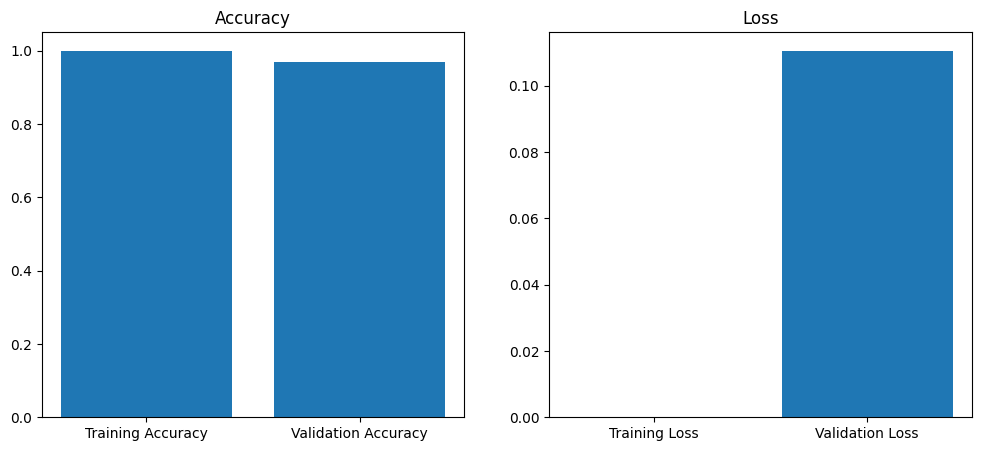

In [36]:
from sklearn.metrics import accuracy_score, log_loss
import matplotlib.pyplot as plt

# Predict on training and test data
y_train_pred = glm.predict(X_train)
y_test_pred = glm.predict(X_test)

# Calculate accuracies
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

# Calculate log losses
y_train_prob = glm.predict_proba(X_train)
y_test_prob = glm.predict_proba(X_test)

train_loss = log_loss(y_train, y_train_prob)
test_loss = log_loss(y_test, y_test_prob)

# Print the results
print(f"Training Accuracy: {train_accuracy}")
print(f"Validation Accuracy: {test_accuracy}")
print(f"Training Loss: {train_loss}")
print(f"Validation Loss: {test_loss}")

# Plot Accuracy and Loss (though logistic regression doesn’t inherently track these over epochs)
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.bar(['Training Accuracy', 'Validation Accuracy'], [train_accuracy, test_accuracy])
plt.title('Accuracy')

# Loss plot
plt.subplot(1, 2, 2)
plt.bar(['Training Loss', 'Validation Loss'], [train_loss, test_loss])
plt.title('Loss')

plt.show()


In [37]:
print("Accuracy on validation set using Logistic Regression: ",glm.score(X_test,y_test))

Accuracy on validation set using Logistic Regression:  0.9694444444444444


<a id="sec2.2.2"></a>
### [2.2.2 Fine Tuning](#sec2.2.2)

Fine tuning on a pretrained model involves training some of the layers instead of freezing all the weights.

In this example, we will be using the pretrained [ResNet](https://arxiv.org/pdf/1512.03385.pdf) for fine tuning, by doing the following:  
1. Freezing the first 171 layers and only training the last 4 layers in Resnet. 
2. Adding our own fully connected layer with 1024 neurons.
3. Add a single neuron Dense layer with sigmoid activation as our classifier.


In [38]:
np.random.seed(2020)

res = resnet.ResNet50(weights='imagenet',
                  include_top=False,
                  input_shape=(224, 224, 3))

res_train_gen = generate_train_batch('resnet')
res_valid_gen = generate_valid_batch('resnet')


for layer in res.layers[:171]:
    layer.trainable=False
    

flat = Flatten()(res.output)   #Flatten the output layer from our Resnet model
dense = Dense(1024,activation='relu')(flat)
drop = Dropout(0.5)(dense)
classifier = Dense(1, activation='sigmoid')(drop)


res_model = Model(res.input, classifier)
optimizer=optimizers.Adam(1e-5)


res_model.compile(optimizer= optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

res_model.summary()


resnet data
Found 3600 validated image filenames belonging to 2 classes.
resnet validation set
Found 1200 validated image filenames belonging to 2 classes.
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )    

In [39]:
history = res_model.fit_generator(res_train_gen,
                    epochs=epochs,
                    validation_data=res_valid_gen,
                    validation_steps=res_train_gen.samples//batch_size,
                    steps_per_epoch = res_valid_gen.samples//batch_size)

C:\Users\dongr\AppData\Local\Temp\ipykernel_14448\2429327575.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = res_model.fit_generator(res_train_gen,


Epoch 1/50
75/75 [==============================] - 43s 496ms/step - loss: 0.2663 - accuracy: 0.9033 - val_loss: 0.0581 - val_accuracy: 0.9808
Epoch 2/50
75/75 [==============================] - 24s 322ms/step - loss: 0.0965 - accuracy: 0.9733
Epoch 3/50
75/75 [==============================] - 21s 283ms/step - loss: 0.0994 - accuracy: 0.9733
Epoch 4/50
75/75 [==============================] - 22s 295ms/step - loss: 0.0595 - accuracy: 0.9825
Epoch 5/50
75/75 [==============================] - 23s 306ms/step - loss: 0.0906 - accuracy: 0.9708
Epoch 6/50
75/75 [==============================] - 22s 290ms/step - loss: 0.0787 - accuracy: 0.9792
Epoch 7/50
75/75 [==============================] - 21s 274ms/step - loss: 0.0703 - accuracy: 0.9800
Epoch 8/50
75/75 [==============================] - 21s 283ms/step - loss: 0.0514 - accuracy: 0.9858
Epoch 9/50
75/75 [==============================] - 21s 282ms/step - loss: 0.0384 - accuracy: 0.9900
Epoch 10/50
75/75 [==============================

In [40]:
loss, accuracy = res_model.evaluate_generator(res_valid_gen, res_valid_gen.samples//batch_size, workers=12)
print("Validation: accuracy = %f  ;  loss = %f " % (accuracy, loss))

C:\Users\dongr\AppData\Local\Temp\ipykernel_14448\3017992511.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  loss, accuracy = res_model.evaluate_generator(res_valid_gen, res_valid_gen.samples//batch_size, workers=12)


Validation: accuracy = 0.985000  ;  loss = 0.085711 


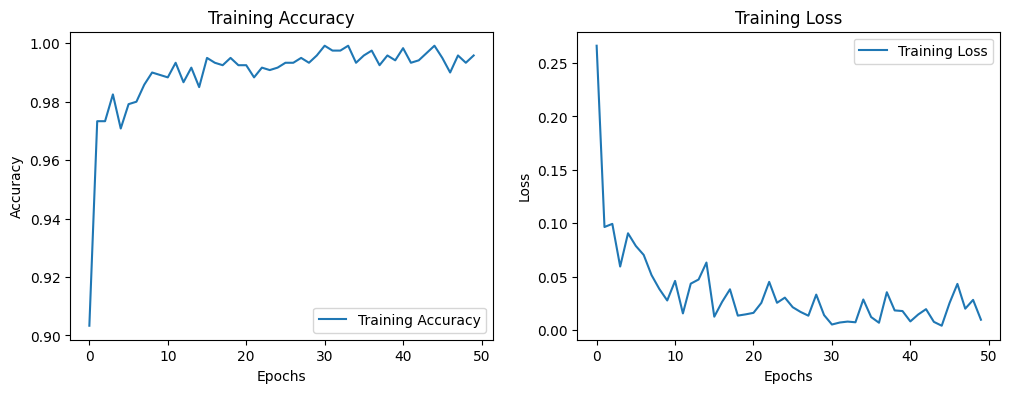

In [42]:
import matplotlib.pyplot as plt

# Assuming `history` is the variable holding the training history
history_dict = history.history

# Extracting values for accuracy, validation accuracy, loss, and validation loss
accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

# Plotting accuracy and validation accuracy
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(accuracy, label='Training Accuracy')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.legend()

# Plotting loss and validation loss
plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

plt.show()

<a id='sec3'></a>
# [3. Results](#sec3)

We will make predictions on 12 images collected from the **test data**, using the 3 architectures we have built thus far; [Custom CNN](#sec2.1), [Feature Extraction](#sec2.2.1) and [Fine Tuning](#sec2.2.2).

In [45]:
# define function for evaluating model performance on test images

testdf = pd.DataFrame({'filename': test_x})
test_sample = testdf.sample(n=12, random_state=2020)

def test_img(model,name):
    result_lst = []
    for path in test_sample['filename'].to_numpy():
        full_path = '../test/'+path
        x = load_img(full_path, target_size=(224,224))
        img_array = img_to_array(x)
        img_array = np.expand_dims(img_array, axis=0)
        if name == 'vgg':
            features = model.predict(img_array)
            features = np.reshape(features,(-1,7*7*512))
            result = glm.predict(features)
        else:
            result =  model.predict(img_array)
        
        result = 'dog' if float(result) >0.5 else 'cat'
        
        result_lst.append(result)
    return result_lst

In [46]:
# get test predictions from all models
custom_cnn_result = test_img(modelcnn, 'cnn')
trflearn_result = test_img(vgg,'vgg')
finetune_result = test_img(res_model,'resnet')

1/1 [==============================] - 0s 31ms/step


C:\Users\dongr\AppData\Local\Temp\ipykernel_14448\4113911229.py:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  result = 'dog' if float(result) >0.5 else 'cat'


1/1 [==============================] - 0s 49ms/step


C:\Users\dongr\AppData\Local\Temp\ipykernel_14448\4113911229.py:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  result = 'dog' if float(result) >0.5 else 'cat'
C:\Users\dongr\AppData\Local\Temp\ipykernel_14448\4113911229.py:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  result = 'dog' if float(result) >0.5 else 'cat'


1/1 [==============================] - 0s 62ms/step


C:\Users\dongr\AppData\Local\Temp\ipykernel_14448\4113911229.py:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  result = 'dog' if float(result) >0.5 else 'cat'
C:\Users\dongr\AppData\Local\Temp\ipykernel_14448\4113911229.py:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  result = 'dog' if float(result) >0.5 else 'cat'


1/1 [==============================] - 0s 53ms/step


C:\Users\dongr\AppData\Local\Temp\ipykernel_14448\4113911229.py:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  result = 'dog' if float(result) >0.5 else 'cat'
C:\Users\dongr\AppData\Local\Temp\ipykernel_14448\4113911229.py:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  result = 'dog' if float(result) >0.5 else 'cat'


1/1 [==============================] - 0s 50ms/step


C:\Users\dongr\AppData\Local\Temp\ipykernel_14448\4113911229.py:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  result = 'dog' if float(result) >0.5 else 'cat'
C:\Users\dongr\AppData\Local\Temp\ipykernel_14448\4113911229.py:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  result = 'dog' if float(result) >0.5 else 'cat'


1/1 [==============================] - 0s 51ms/step


C:\Users\dongr\AppData\Local\Temp\ipykernel_14448\4113911229.py:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  result = 'dog' if float(result) >0.5 else 'cat'
C:\Users\dongr\AppData\Local\Temp\ipykernel_14448\4113911229.py:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  result = 'dog' if float(result) >0.5 else 'cat'


1/1 [==============================] - 0s 45ms/step


C:\Users\dongr\AppData\Local\Temp\ipykernel_14448\4113911229.py:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  result = 'dog' if float(result) >0.5 else 'cat'
C:\Users\dongr\AppData\Local\Temp\ipykernel_14448\4113911229.py:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  result = 'dog' if float(result) >0.5 else 'cat'


1/1 [==============================] - 0s 47ms/step


The architecture using Transfer Learning and Fine tuning makes pretty good prediction, agreeing with each other on almost all the images, except one, which the Fine tuning method has incorrectly predicted a Dog as Cat. Our Custom CNN doesnt really work very well with alot of false positive (missclassifying Cats as Dogs).

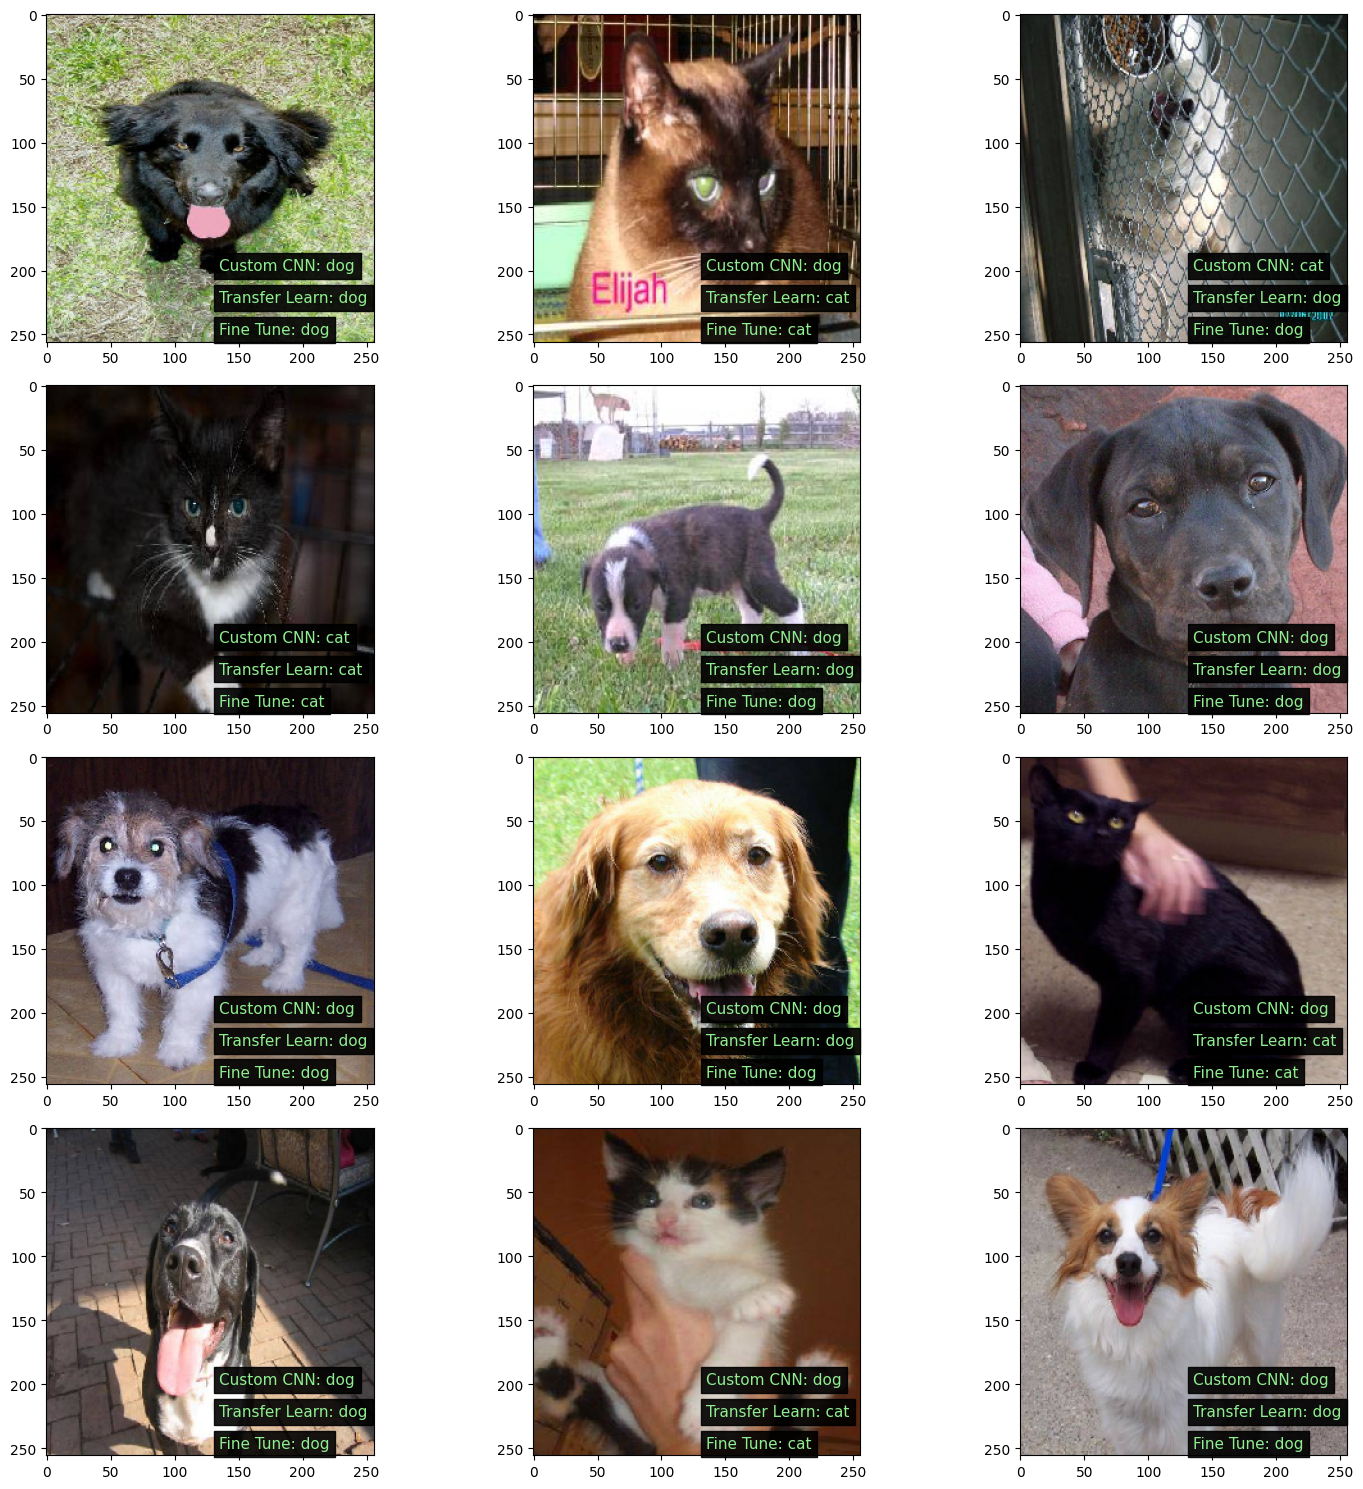

In [47]:
# plotting images with prediction
pred_results  = list(zip(custom_cnn_result,trflearn_result,finetune_result))
test_array = test_sample['filename'].to_numpy()

plt.figure(figsize=(15, 15))
for i in range(0, 12):
    plt.subplot(4, 3, i+1)
    cust,tf,ft = pred_results[i]
    img = test_array[i]
    path = '../test/' + img
    image = load_img(path, target_size=(256,256))
    plt.text(135, 200, 'Custom CNN: {}'.format(cust), color='lightgreen',fontsize= 11, bbox=dict(facecolor='black', alpha=0.9))
    plt.text(135, 225, 'Transfer Learn: {}'.format(tf), color='lightgreen',fontsize= 11, bbox=dict(facecolor='black', alpha=0.9))
    plt.text(135, 250, 'Fine Tune: {}'.format(ft), color='lightgreen',fontsize= 11, bbox=dict(facecolor='black', alpha=0.9))
    plt.imshow(image)

plt.tight_layout()
plt.show()

#### Learning Points
1. Setting a learning rate small enough is very important in the case of Transfer Learning and Fine Tuning, as i realized that setting learning rate to be 1e-4 will result in very low accuracy ~50%. This could be due to the complex loss function, thus, causing divergence during gradient updates if learning rate is not small enough.
2. Images passed into ResNet needs to be preprocessed via the specific preprocessing function provided *from keras.applications.resnet50 import preprocess_input* when generating mini-batches, as it will affect the performance of ResNet if standard preprocessing is done instead.
3. Due to memory constraint from Kaggle Kernel (~13GB), there is possibility of the kernel crashing. What i did to mitigate this is to use the *del* function, to remove some of the variables; feature output object from VGG16. I believe there are much better ways to do it, any advice from the experienced Kagglers will be much appreciated :)